In [79]:
# imports for using the notebook

import pandas as pd
import sys
sys.path.append('../')
from embedding_functions_hugo.embedding_functions import *
from sklearn.preprocessing import StandardScaler
import numpy as np
from numpy import genfromtxt
import nltk
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, FeatureAgglomeration
from sklearn.decomposition import PCA
import seaborn as sns
import networkx as nx

In [80]:
# Specifying datasets from different reddit pages

df_gaming = pd.read_csv('../data/scrapes/gaming.csv')
df_satis = pd.read_csv('../data/scrapes/SatisfactoryGame.csv')
df_marauders = pd.read_csv('../data/scrapes/MaraudersGame.csv')
df_tarkov = pd.read_csv('../data/scrapes/EscapefromTarkov.csv')
df_politics = pd.read_csv('../data/scrapes/politics.csv')


# Datasets post cleaning the text
# df_politics['cleaned_text'] = prep_pipeline(df_politics, 'comment_text')
# df_politics['short'] = shorten_sens(df_politics['cleaned_text'], 50)

# Function to speed up the process: 

def shorten_and_clean_dataset (comment_csv, comment_column : str, desired_comment_length : int):
    dataframe = pd.read_csv(comment_csv)
    dataframe['cleaned_text'] = prep_pipeline(dataframe, comment_column)
    dataframe['short'] = shorten_sens(dataframe['cleaned_text'], desired_comment_length)
    return dataframe

In [81]:
# sen_leng = []
# for i in df_politics['short']:
#     sen_leng.append(len(i.split()))


# print(np.percentile(sen_leng, 25))
# print(np.percentile(sen_leng, 50))
# print(np.percentile(sen_leng, 75))
# print(np.percentile(sen_leng, 99))
# print(np.mean(sen_leng))
# print(np.median(sen_leng))

In [82]:
# authors = df_politics.values[:,-2]

In [83]:
def save_embeddings_as_npy(destination_path : str, comment_csv, comment_column : str, desired_comment_length : int):
    '''
    Nlp pipeline function which takes a pandas dataframe and relevant columns, performs preprocessing steps, uses sentence_transformer embeddings and saves the embeddings as a csv file.
    '''
    sentences = shorten_and_clean_dataset(comment_csv, comment_column, desired_comment_length)
    embeddings = embed_comments(sentences['short'])
    return np.save(destination_path, embeddings)
   # return savetxt(destination_path, embeddings, delimiter = ',')

### UNCOMMENT BELOW TO DO EMBEDDINGS AND SAVE THEM

# save_embeddings_as_npy('../data/embeddings/politics_embeddings.npy', '../data/scrapes/politics.csv', 'comment_text', 50)
# save_embeddings_as_npy('../data/embeddings/gaming_embeddings.npy', '../data/scrapes/gaming.csv', 'comment_text', 50)
# save_embeddings_as_npy('../data/embeddings/marauders_embeddings.npy', '../data/scrapes/MaraudersGame.csv', 'comment_text', 50)
# save_embeddings_as_npy('../data/embeddings/tarkov_embeddings.npy', '../data/scrapes/EscapefromTarkov.csv', 'comment_text', 50)
# save_embeddings_as_npy('../data/embeddings/satisfactory_embeddings.npy', '../data/scrapes/SatisfactoryGame.csv', 'comment_text', 50)

In [84]:
def pair_users_embeddings(dataframe, embeddings, average_out_comments = False):
    usernames = dataframe['comment_author']
    user_dictionary = {}
    for author, embedded_comment in zip(usernames, embeddings):
        if author not in user_dictionary.keys():
            user_dictionary[author] = []
            user_dictionary[author].append(embedded_comment)
        else:
            user_dictionary[author].append(embedded_comment)
    if average_out_comments:
        for user in user_dictionary:
            number_or_comments = len(user_dictionary[user])
            user_dictionary[user] = sum(user_dictionary[user])/number_or_comments
    return user_dictionary

In [85]:
# LOADING EMBEDDINGS FROM FILES

politics_embeddings = np.load('../data/embeddings/politics_embeddings.npy')
gaming_embeddings = np.load('../data/embeddings/gaming_embeddings.npy')
marauders_embeddings = np.load('../data/embeddings/marauders_embeddings.npy')
tarkov_embeddings = np.load('../data/embeddings/tarkov_embeddings.npy')

# include below when the satisfactory embeddings are done
# satisfactory_embeddings = np.load('../data/embeddings/satisfactory_embeddings.npy')

In [86]:
politics_user_embeddings = pair_users_embeddings(df_politics, politics_embeddings, True)

In [87]:
# pca = PCA(n_components=2)
# two_dimensional_embeddings = pca.fit_transform(list(politics_user_embeddings.values()))

# kmeans = KMeans(n_clusters=2)

# classes = kmeans.fit_predict(two_dimensional_embeddings)

In [88]:
def reduce_dims_and_kmeans(user_embedding_pairs, num_of_dimensions):
    '''
    Current version only works w 2 colors. 
    '''
    # Set PCA to desired number of dimensions
    pca = PCA(n_components=num_of_dimensions)


    pca_embeddings = pca.fit_transform(list(user_embedding_pairs.values()))

    kmeans = KMeans(n_clusters=2, random_state=0) 

    classes = kmeans.fit_predict(pca_embeddings)


    label_color_map = {0 : 'r',1 : 'g'}
    label_color = [label_color_map[l] for l in classes]
    plt.scatter(pca_embeddings[:,0], pca_embeddings[:,1], c=label_color)

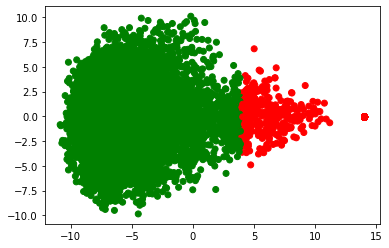

In [89]:
reduce_dims_and_kmeans(politics_user_embeddings, 2)

In [90]:
def reduce_to_one_dimension_kmeans(user_embedding_pairs):
    '''
    Current version only works w 2 colors. 
    '''
    # Set PCA to desired number of dimensions
    pca = PCA(n_components=1)


    pca_embeddings = pca.fit_transform(list(user_embedding_pairs.values()))

    kmeans = KMeans(n_clusters=2, random_state=0) 

    classes = kmeans.fit_predict(pca_embeddings)

    return (user_embedding_pairs.keys(), classes)

politics_user_embeddings = pair_users_embeddings(df_politics, politics_embeddings, True)
Squeem = reduce_to_one_dimension_kmeans(politics_user_embeddings)
x_axis = []
for name,emb in zip(Squeem[0], Squeem[1]):
    x_axis.append([str(name),emb])

def sortie(beb):
    return beb[0]
x_axis = sorted(x_axis, key=sortie)
len(x_axis)

10384

In [91]:
# Test for making new dataframe with columns: 
# should be exportable to networkx - preferably edgelist
# Author (node_id),pca_x-axis , post_id

authors = []
x_axis = []
posts = []

# df_politics = df_politics.drop('post_text', axis=1).dropna()
df_politics

,post_title,post_text,post_id,post_score,post_total_comments,post_url,comment_author,comment_text
0,"Trump Must Pay Hillary Clinton $171,631 in Leg...",NaN,10h1dc6,68511,2003,https://www.reddit.com/r/politics/comments/10h...,AutoModerator,"\nAs a reminder, this subreddit [is for civil ..."
1,"Trump Must Pay Hillary Clinton $171,631 in Leg...",NaN,10h1dc6,68511,2003,https://www.reddit.com/r/politics/comments/10h...,PandaMuffin1,> Hours after Middlebrooks' filing became pub...
2,"Trump Must Pay Hillary Clinton $171,631 in Leg...",NaN,10h1dc6,68511,2003,https://www.reddit.com/r/politics/comments/10h...,Dagonet_the_Motley,LOL imagine all the suckers who gave money to ...
3,"Trump Must Pay Hillary Clinton $171,631 in Leg...",NaN,10h1dc6,68511,2003,https://www.reddit.com/r/politics/comments/10h...,lufecaep,They should double it every time he tries to a...
4,"Trump Must Pay Hillary Clinton $171,631 in Leg...",NaN,10h1dc6,68511,2003,https://www.reddit.com/r/politics/comments/10h...,FortySixAndYou,"So, this is on top of the $1M in sanctions tha..."
...,...,...,...,...,...,...,...,...
14128,"Biden Will Call for Billionaire Tax, Bigger Le...",NaN,10w6mwm,13934,696,https://www.reddit.com/r/politics/comments/10w...,seyfert3,Hopefully this is a progressive wealth tax sta...
14129,"Biden Will Call for Billionaire Tax, Bigger Le...",NaN,10w6mwm,13934,696,https://www.reddit.com/r/politics/comments/10w...,Status-Stick,"K, call for it all you want. Or do something"
14130,"Biden Will Call for Billionaire Tax, Bigger Le...",NaN,10w6mwm,13934,696,https://www.reddit.com/r/politics/comments/10w...,Ill_Needleworker2626,"believe it when i see it. prove me wrong, that..."
14131,"Biden Will Call for Billionaire Tax, Bigger Le...",NaN,10w6mwm,13934,696,https://www.reddit.com/r/politics/comments/10w...,SlmDckns,Why can’t we get more tax on millionaires. The...


In [92]:
df_politics = df_politics.sort_values(by='comment_author')
for ball in df_politics.iloc:
    ID, Author = ball[2], ball[6]
    authors.append(Author)
    posts.append(ID)

In [93]:
edge_list = []
for i, j in zip(authors, posts):
    edge_list.append((i,j))

In [94]:
n1 = nx.from_edgelist(edgelist=edge_list)
nx.set_node_attributes(n1, Squeem, 'classes')

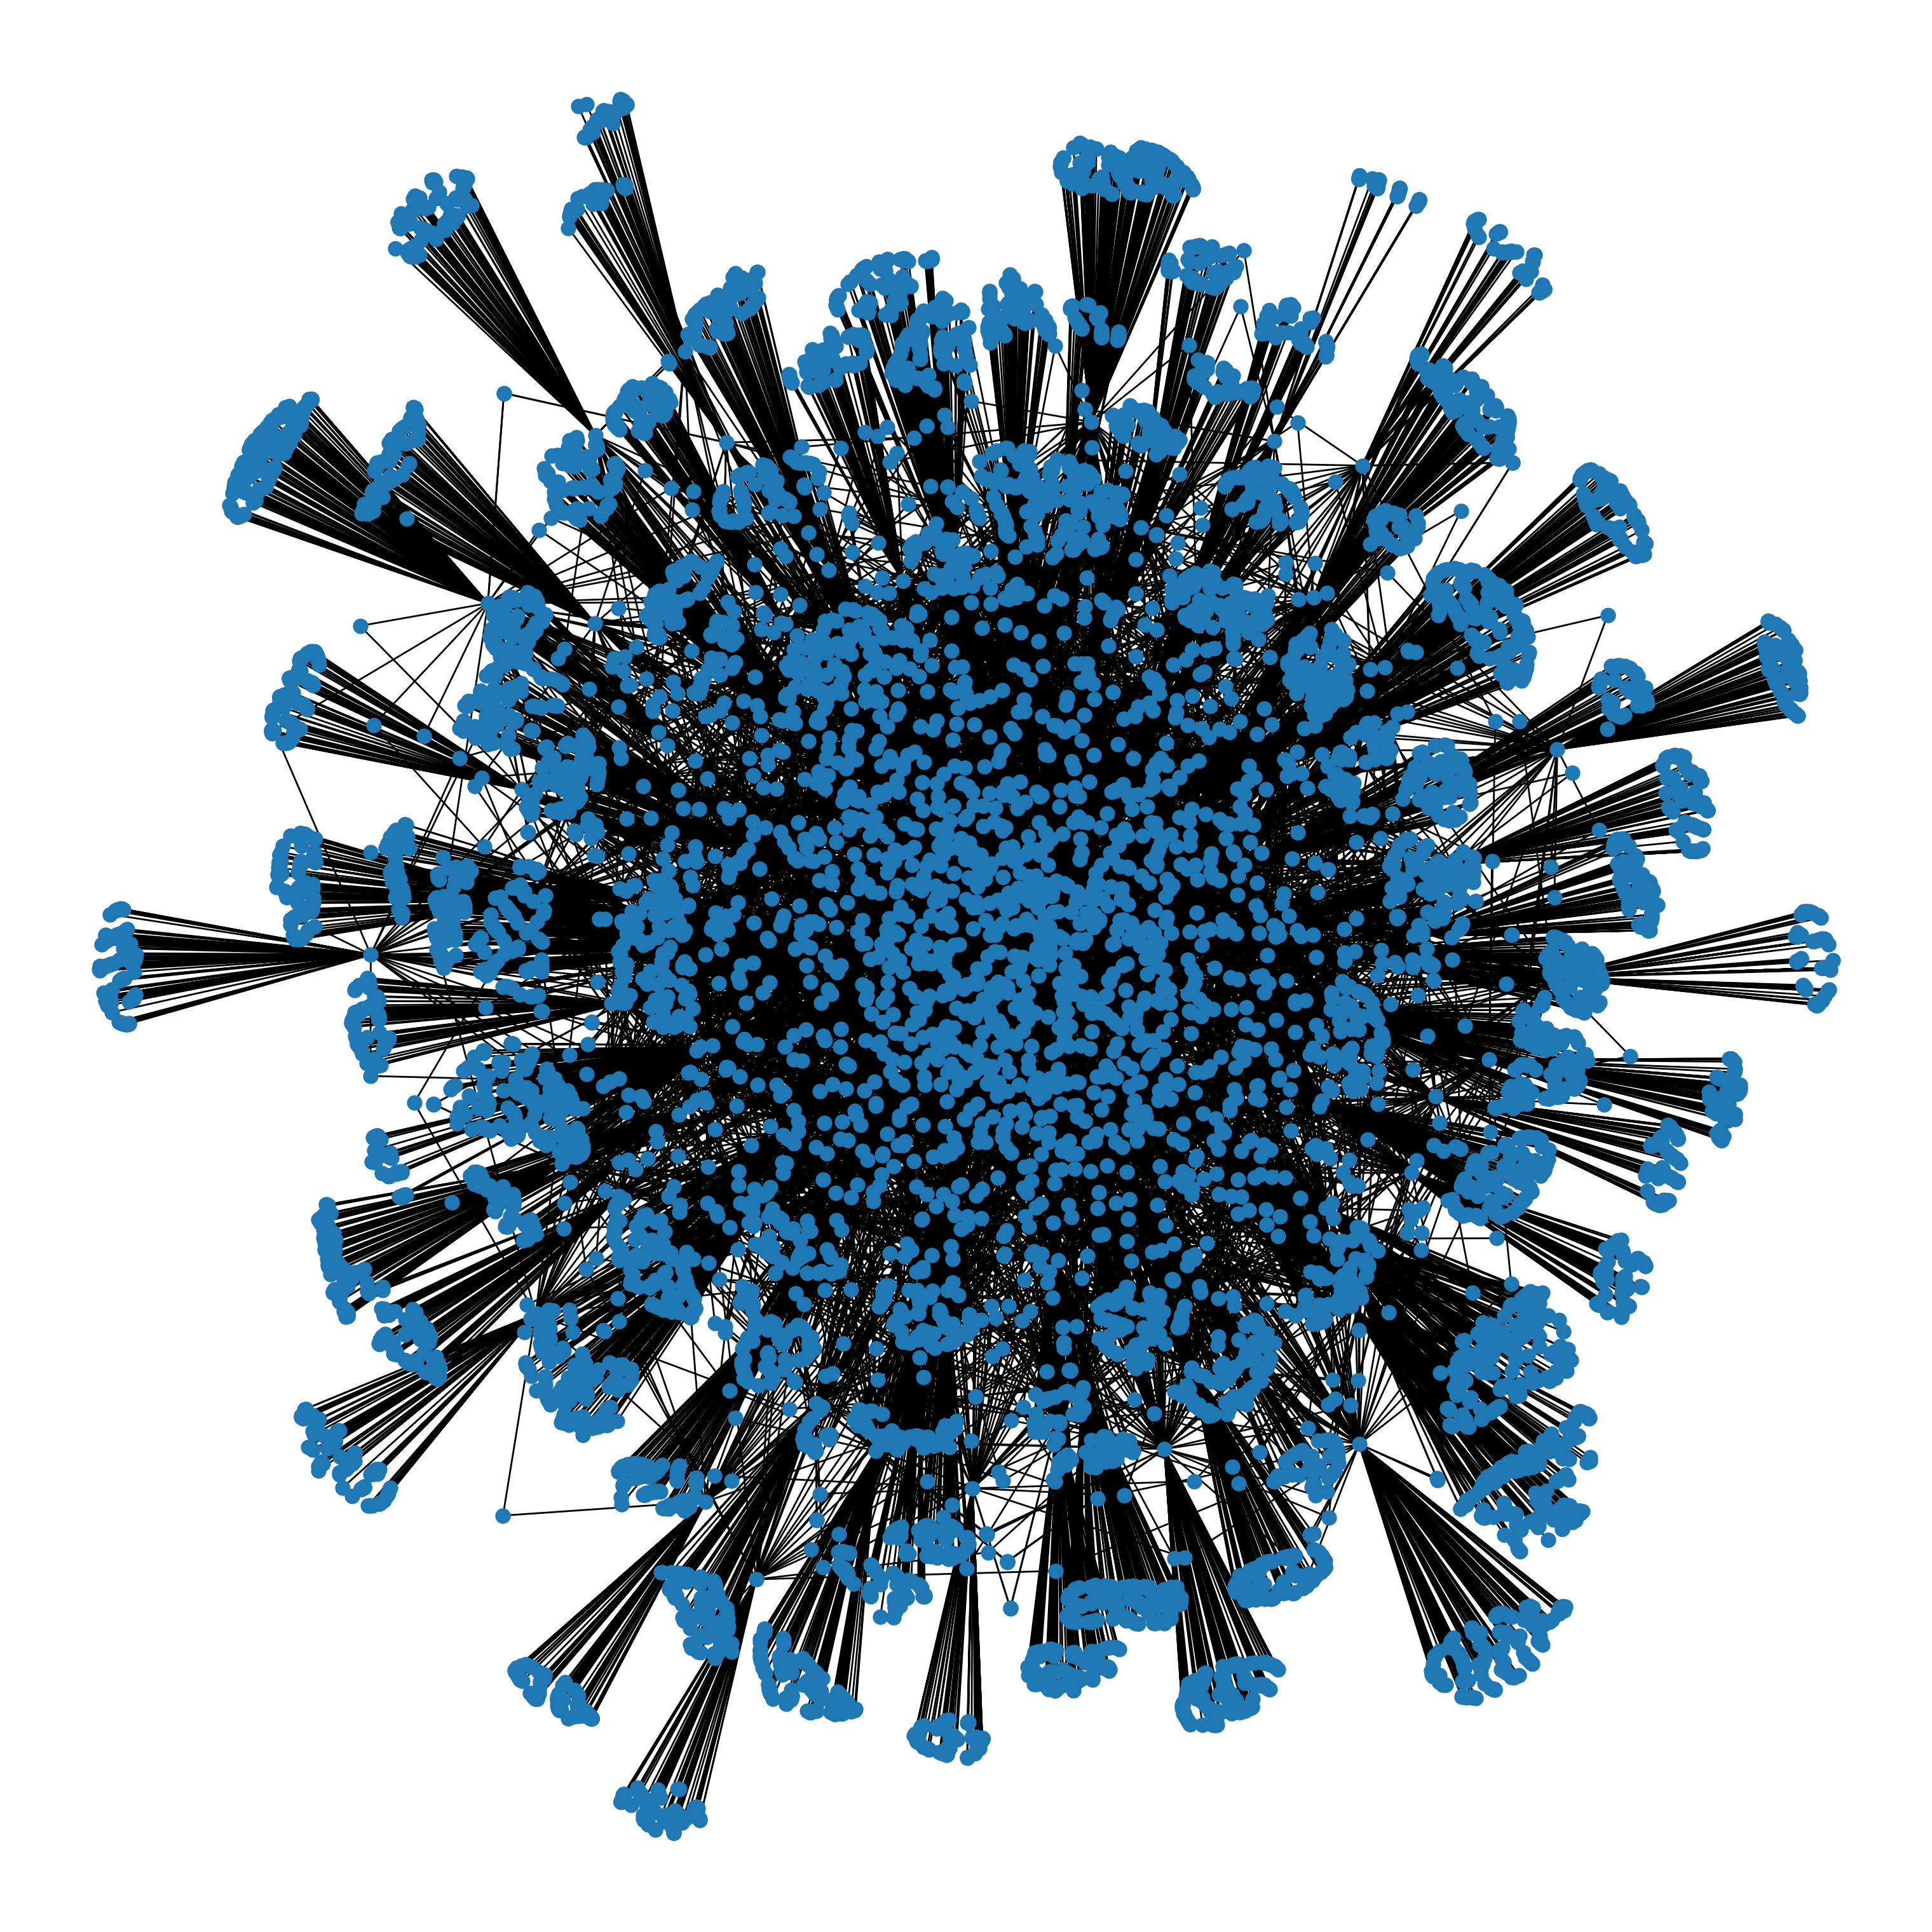

In [95]:
plt.figure(1, figsize= (15, 15), dpi=200)
nx.draw(n1,node_size = 60, font_size=8)

In [96]:
n1.nodes

NodeView(('---------0----------', '10mzhtl', '---Blix---', '10f6vtq', '--harumph--', '10d29v4', '-AngryPope', '10cuh0o', '-CJF-', '10yqipm', '-ChiefLongBeef-', '-CoachMcGuirk-', '10q3gfj', '-Degaussed-', '10y609l', '-Economist-', '10dcff1', '-Great-Scott-', '10v59z2', '-Hypnotoad26', '10ywd7x', '10yy47m', '10yqvho', '-November15th-', '10phzu3', '-Rem_Lezar69', '10zk2rj', '-The-Baba-Jaga-', '10l6f8w', '-Why-Not-This-Name-', '10uc30t', '-bferis-', '10nczjx', '-but-its-not-illegal', '10guv8x', '-flame-retardant-', '10h1dc6', '-metaphased-', '10npfl3', '-praetorr-', '10tx32j', '00000000000004000000', '10gf7a4', '007meow', '10je96i', '013ander', '10p6db4', '0235', '10kokoi', '0DarkNerdy', '10wy3bv', '0nlyhalfjewish', '10dy5rj', '10lqstv', '0ogaBooga', '10e0s84', '10-10--01-01', '10s0cp9', '1000_pi10ts', '10eckb1', '100farts', '1015267', '1025Traveller', '108awake-', '10g0gcp', '10minutes_late', '10strip', '10qtmod', '11timesover', '10o6tdf', '12358', '12jresult', '10qvjog', '1313pd1313', '1